## Import Dataset

In [8]:
import os

import numpy
from torchvision import transforms
from torch.utils.data import DataLoader
from oracle import MNIST, OracleMNIST

# 普通CNN模型
# 原始代码和模型参考自 https://github.com/Tanuj-tj/Flowers_Recognition_Project/blob/main/FlowerReco_ResNet9.ipynb

batch_size = 64
dataSource = lambda train: MNIST(root="datasets", train=train, download=True, transform=transforms.ToTensor())
# dataSource = lambda train: OracleMNIST(root="datasets", train=train, download=True, transform=transforms.ToTensor())

trainData = dataSource(True)
testData = dataSource(False)
trainDL = DataLoader(trainData, batch_size, shuffle=True, num_workers=os.cpu_count(), pin_memory=True)
testDL = DataLoader(testData, batch_size, num_workers=os.cpu_count(), pin_memory=True)

## Dataset preview

TrainData Length:  60000
TestData Length:  10000
Classes:  ['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']
A Perticular Element:  torch.Size([1, 28, 28]) Label:  5 - five


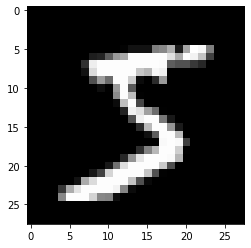

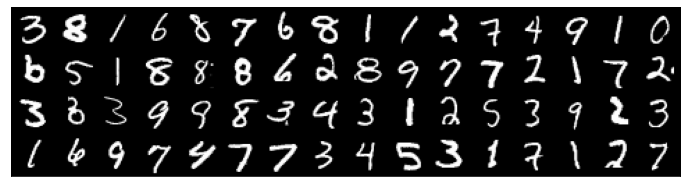

In [9]:
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

print("TrainData Length: ", len(trainData))
print("TestData Length: ", len(testData))
print("Classes: ", trainData.classes)

img, label = trainData[0]
print("A Perticular Element: ", img.shape, "Label: ", trainData.classes[label])
plt.imshow(img[0], cmap="gray")  # Looking at the first image
del img, label


def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images[:64], nrow=16).permute(1, 2, 0))
        break


show_batch(trainDL)

## Model Utilities

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm.auto import tqdm, trange


def mergeResult(mode, outputs):
    loss = torch.stack([x[0] for x in outputs]).mean().item()
    acc = numpy.average([x[1] for x in outputs])
    return {mode + '_loss': loss, mode + '_acc': acc}


@torch.no_grad()
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))


def step(model, batch):
    images, labels = batch
    out = model(images)  # Generate predictions
    loss = F.cross_entropy(out, labels)  # Calculate loss
    acc = accuracy(out, labels)  # Calculate accuracy
    return loss, acc


@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    val_loader = tqdm(val_loader, "evaluate", leave=False)
    outputs = [step(model, batch) for batch in val_loader]
    return mergeResult('val', outputs)


def fit(model, optimizer, epoch, train_loader, val_loader):
    # Training Phase
    model.train()
    outputs = []
    for batch in tqdm(train_loader, "train", leave=False):
        (loss, acc) = step(model, batch)
        outputs.append((loss, acc))
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    result = mergeResult('train', outputs)
    # Validation phase
    result.update(evaluate(model, val_loader))
    return result


def plot_accuracies(history):
    accuraciesT = [x.get('train_acc') for x in history]
    accuraciesV = [x.get('val_acc') for x in history]
    plt.plot(accuraciesT, '-bx')
    plt.plot(accuraciesV, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend(['Training', 'Validation'])
    plt.title('Accuracy vs. No. of epochs')


def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x.get('val_loss') for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs')

### Device Util

In [11]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)


class DeviceDataLoader:
    """Wrap a dataloader to move data to a device"""

    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)


if os.getenv('COLAB_TPU_ADDR'):
    get_ipython().system(
        "pip install cloud-tpu-client==0.10 torch==1.11.0 https://storage.googleapis.com/tpu-pytorch/wheels/colab/torch_xla-1.11-cp37-cp37m-linux_x86_64.whl")
    import torch_xla.core.xla_model as xm

    device = xm.xla_device()
else:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device", device)

if not (trainDL is DeviceDataLoader):
    trainDL = DeviceDataLoader(trainDL, device)
    testDL = DeviceDataLoader(testDL, device)

device cuda


## Model

In [12]:
def conv_block(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
        nn.MaxPool2d(2, 2),
        nn.ReLU(inplace=True),
    )


def linear_ReLU(in_channels, out_channels):
    return nn.Sequential(
        nn.Linear(in_channels, out_channels),
        nn.ReLU(),
    )


class CNN(nn.Sequential):
    def __init__(self, in_channels, num_classes):
        super().__init__(
            conv_block(in_channels, 64),
            conv_block(64, 128),
            nn.Flatten(),
            linear_ReLU(128 * 7 * 7, 1024),
            nn.Dropout(p=0.2),
            nn.Linear(1024, num_classes)
        )


CNN(1, len(trainData.classes))

CNN(
  (0): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU(inplace=True)
  )
  (1): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU(inplace=True)
  )
  (2): Flatten(start_dim=1, end_dim=-1)
  (3): Sequential(
    (0): Linear(in_features=6272, out_features=1024, bias=True)
    (1): ReLU()
  )
  (4): Dropout(p=0.2, inplace=False)
  (5): Linear(in_features=1024, out_features=10, bias=True)
)

## Training

In [13]:
def doEpoch(epoch):
    result = fit(model, optimizer, epoch, trainDL, testDL)
    result["lr"] = optimizer.state_dict()['param_groups'][0]['lr']
    scheduler.step(result['train_acc'])
    tqdm.write("Epoch [%d] %s" % (epoch, result))
    history.append(result)


def doRound(round):
    global model, optimizer, scheduler, history
    model = CNN(1, len(trainData.classes)).to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, threshold_mode='rel', mode='max', patience=1, verbose=False,
        threshold=0.1, factor=0.3, min_lr=0.001)
    history = [evaluate(model, testDL)]

    for epoch in trange(12, desc="EPOCH", leave=False):
        doEpoch(epoch)

    plt.subplot(1, 2, 1)
    plot_accuracies(history)
    plt.subplot(1, 2, 2)
    plot_losses(history)
    plt.show()
    result = history[-1]
    tqdm.write("Round [%d], train_loss: %.4f, train_acc: %.4f, val_loss: %.4f, val_acc: %.4f, lr: %f" %
               (round, result['train_loss'], result['train_acc'], result['val_loss'], result['val_acc'], result["lr"]))
    train_acc.append(history[-1]["train_acc"])
    val_acc.append(history[-1]["val_acc"])

ROUND:   0%|          | 0/3 [00:00<?, ?it/s]

evaluate:   0%|          | 0/157 [00:00<?, ?it/s]

EPOCH:   0%|          | 0/12 [00:00<?, ?it/s]

train:   0%|          | 0/938 [00:00<?, ?it/s]

evaluate:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch [0] {'train_loss': 0.25097450613975525, 'train_acc': 0.9200093, 'val_loss': 0.06881153583526611, 'val_acc': 0.9780056, 'lr': 0.1}


train:   0%|          | 0/938 [00:00<?, ?it/s]

evaluate:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch [1] {'train_loss': 0.061067383736371994, 'train_acc': 0.98135996, 'val_loss': 0.05826609954237938, 'val_acc': 0.9793989, 'lr': 0.1}


train:   0%|          | 0/938 [00:00<?, ?it/s]

evaluate:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch [2] {'train_loss': 0.04152993857860565, 'train_acc': 0.9868737, 'val_loss': 0.03565964847803116, 'val_acc': 0.9882564, 'lr': 0.1}


train:   0%|          | 0/938 [00:00<?, ?it/s]

evaluate:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch [3] {'train_loss': 0.025775503367185593, 'train_acc': 0.9923208, 'val_loss': 0.026010964065790176, 'val_acc': 0.99164015, 'lr': 0.03}


train:   0%|          | 0/938 [00:00<?, ?it/s]

evaluate:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch [4] {'train_loss': 0.02184080146253109, 'train_acc': 0.99365336, 'val_loss': 0.024755872786045074, 'val_acc': 0.99124205, 'lr': 0.03}


train:   0%|          | 0/938 [00:00<?, ?it/s]

evaluate:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch [5] {'train_loss': 0.018343716859817505, 'train_acc': 0.99441963, 'val_loss': 0.023076118901371956, 'val_acc': 0.99213773, 'lr': 0.009}


train:   0%|          | 0/938 [00:00<?, ?it/s]

evaluate:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch [6] {'train_loss': 0.017073292285203934, 'train_acc': 0.9950027, 'val_loss': 0.02307785302400589, 'val_acc': 0.99213773, 'lr': 0.009}


train:   0%|          | 0/938 [00:00<?, ?it/s]

evaluate:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch [7] {'train_loss': 0.016057047992944717, 'train_acc': 0.9955857, 'val_loss': 0.022662268951535225, 'val_acc': 0.9923368, 'lr': 0.0026999999999999997}


train:   0%|          | 0/938 [00:00<?, ?it/s]

evaluate:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch [8] {'train_loss': 0.015948772430419922, 'train_acc': 0.9954857, 'val_loss': 0.022633245214819908, 'val_acc': 0.9923368, 'lr': 0.0026999999999999997}


train:   0%|          | 0/938 [00:00<?, ?it/s]

evaluate:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch [9] {'train_loss': 0.015188433229923248, 'train_acc': 0.99571896, 'val_loss': 0.022679230198264122, 'val_acc': 0.9923368, 'lr': 0.001}


train:   0%|          | 0/938 [00:00<?, ?it/s]

evaluate:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch [10] {'train_loss': 0.01553844753652811, 'train_acc': 0.99568564, 'val_loss': 0.022746741771697998, 'val_acc': 0.9924363, 'lr': 0.001}


train:   0%|          | 0/938 [00:00<?, ?it/s]

evaluate:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch [11] {'train_loss': 0.01477569155395031, 'train_acc': 0.99591887, 'val_loss': 0.022746941074728966, 'val_acc': 0.9923368, 'lr': 0.001}


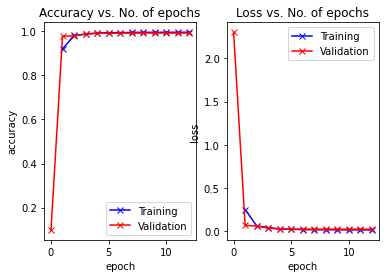

Round [0], train_loss: 0.0148, train_acc: 0.9959, val_loss: 0.0227, val_acc: 0.9923, lr: 0.001000


evaluate:   0%|          | 0/157 [00:00<?, ?it/s]

EPOCH:   0%|          | 0/12 [00:00<?, ?it/s]

train:   0%|          | 0/938 [00:00<?, ?it/s]

evaluate:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch [0] {'train_loss': 0.24568067491054535, 'train_acc': 0.9221582, 'val_loss': 0.0679364949464798, 'val_acc': 0.977707, 'lr': 0.1}


train:   0%|          | 0/938 [00:00<?, ?it/s]

evaluate:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch [1] {'train_loss': 0.06471214443445206, 'train_acc': 0.97991073, 'val_loss': 0.04744614288210869, 'val_acc': 0.9849721, 'lr': 0.1}


train:   0%|          | 0/938 [00:00<?, ?it/s]

evaluate:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch [2] {'train_loss': 0.04451771453022957, 'train_acc': 0.9861074, 'val_loss': 0.037871602922677994, 'val_acc': 0.9876592, 'lr': 0.1}


train:   0%|          | 0/938 [00:00<?, ?it/s]

evaluate:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch [3] {'train_loss': 0.026257093995809555, 'train_acc': 0.9923541, 'val_loss': 0.026836080476641655, 'val_acc': 0.991043, 'lr': 0.03}


train:   0%|          | 0/938 [00:00<?, ?it/s]

evaluate:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch [4] {'train_loss': 0.023198530077934265, 'train_acc': 0.99305373, 'val_loss': 0.025127988308668137, 'val_acc': 0.991043, 'lr': 0.03}


train:   0%|          | 0/938 [00:00<?, ?it/s]

evaluate:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch [5] {'train_loss': 0.01861852966248989, 'train_acc': 0.9942697, 'val_loss': 0.023370184004306793, 'val_acc': 0.99124205, 'lr': 0.009}


train:   0%|          | 0/938 [00:00<?, ?it/s]

evaluate:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch [6] {'train_loss': 0.0177043154835701, 'train_acc': 0.9949527, 'val_loss': 0.02360820770263672, 'val_acc': 0.9915406, 'lr': 0.009}


train:   0%|          | 0/938 [00:00<?, ?it/s]

evaluate:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch [7] {'train_loss': 0.016274873167276382, 'train_acc': 0.9954191, 'val_loss': 0.023598995059728622, 'val_acc': 0.99134153, 'lr': 0.0026999999999999997}


train:   0%|          | 0/938 [00:00<?, ?it/s]

evaluate:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch [8] {'train_loss': 0.015847384929656982, 'train_acc': 0.9955024, 'val_loss': 0.02323688380420208, 'val_acc': 0.99134153, 'lr': 0.0026999999999999997}


train:   0%|          | 0/938 [00:00<?, ?it/s]

evaluate:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch [9] {'train_loss': 0.016122564673423767, 'train_acc': 0.9953025, 'val_loss': 0.023225802928209305, 'val_acc': 0.99134153, 'lr': 0.001}


train:   0%|          | 0/938 [00:00<?, ?it/s]

evaluate:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch [10] {'train_loss': 0.015767324715852737, 'train_acc': 0.99521923, 'val_loss': 0.023192090913653374, 'val_acc': 0.9914411, 'lr': 0.001}


train:   0%|          | 0/938 [00:00<?, ?it/s]

evaluate:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch [11] {'train_loss': 0.015658225864171982, 'train_acc': 0.99568564, 'val_loss': 0.023195328190922737, 'val_acc': 0.9914411, 'lr': 0.001}


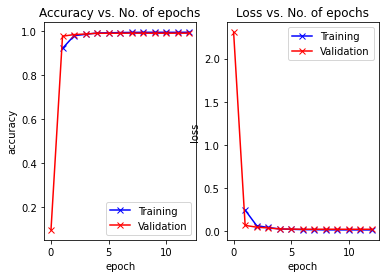

Round [1], train_loss: 0.0157, train_acc: 0.9957, val_loss: 0.0232, val_acc: 0.9914, lr: 0.001000


evaluate:   0%|          | 0/157 [00:00<?, ?it/s]

EPOCH:   0%|          | 0/12 [00:00<?, ?it/s]

train:   0%|          | 0/938 [00:00<?, ?it/s]

evaluate:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch [0] {'train_loss': 0.25114622712135315, 'train_acc': 0.92054236, 'val_loss': 0.05840393900871277, 'val_acc': 0.98158836, 'lr': 0.1}


train:   0%|          | 0/938 [00:00<?, ?it/s]

evaluate:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch [1] {'train_loss': 0.06171482056379318, 'train_acc': 0.9811434, 'val_loss': 0.042992737144231796, 'val_acc': 0.9849721, 'lr': 0.1}


train:   0%|          | 0/938 [00:00<?, ?it/s]

evaluate:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch [2] {'train_loss': 0.04227220267057419, 'train_acc': 0.9869903, 'val_loss': 0.032034218311309814, 'val_acc': 0.99004775, 'lr': 0.1}


train:   0%|          | 0/938 [00:00<?, ?it/s]

evaluate:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch [3] {'train_loss': 0.025632094591856003, 'train_acc': 0.9925373, 'val_loss': 0.027551110833883286, 'val_acc': 0.99024683, 'lr': 0.03}


train:   0%|          | 0/938 [00:00<?, ?it/s]

evaluate:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch [4] {'train_loss': 0.021585311740636826, 'train_acc': 0.9937533, 'val_loss': 0.02620025910437107, 'val_acc': 0.99164015, 'lr': 0.03}


train:   0%|          | 0/938 [00:00<?, ?it/s]

evaluate:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch [5] {'train_loss': 0.018359392881393433, 'train_acc': 0.9946862, 'val_loss': 0.02488616853952408, 'val_acc': 0.99124205, 'lr': 0.009}


train:   0%|          | 0/938 [00:00<?, ?it/s]

evaluate:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch [6] {'train_loss': 0.0171723160892725, 'train_acc': 0.99491936, 'val_loss': 0.02417846769094467, 'val_acc': 0.99213773, 'lr': 0.009}


train:   0%|          | 0/938 [00:00<?, ?it/s]

evaluate:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch [7] {'train_loss': 0.01582646183669567, 'train_acc': 0.9953358, 'val_loss': 0.023743093013763428, 'val_acc': 0.9918392, 'lr': 0.0026999999999999997}


train:   0%|          | 0/938 [00:00<?, ?it/s]

evaluate:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch [8] {'train_loss': 0.0157316941767931, 'train_acc': 0.99555236, 'val_loss': 0.023665884509682655, 'val_acc': 0.9919387, 'lr': 0.0026999999999999997}


train:   0%|          | 0/938 [00:00<?, ?it/s]

evaluate:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch [9] {'train_loss': 0.015282991342246532, 'train_acc': 0.99555236, 'val_loss': 0.023566432297229767, 'val_acc': 0.9920382, 'lr': 0.001}


train:   0%|          | 0/938 [00:00<?, ?it/s]

evaluate:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch [10] {'train_loss': 0.015035383403301239, 'train_acc': 0.99555236, 'val_loss': 0.023597577586770058, 'val_acc': 0.9918392, 'lr': 0.001}


train:   0%|          | 0/938 [00:00<?, ?it/s]

evaluate:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch [11] {'train_loss': 0.014995633624494076, 'train_acc': 0.99556905, 'val_loss': 0.023604949936270714, 'val_acc': 0.9920382, 'lr': 0.001}


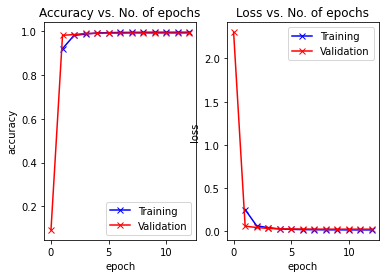

Round [2], train_loss: 0.0150, train_acc: 0.9956, val_loss: 0.0236, val_acc: 0.9920, lr: 0.001000
Train Accuracy: 0.996±0.0001
[0.99591887, 0.99568564, 0.99556905]
Test Accuracy: 0.992±0.0004
[0.9923368, 0.9914411, 0.9920382]


In [14]:
train_acc = []
val_acc = []
ALL_ROUND = 3
for round in trange(ALL_ROUND, desc="ROUND"):
    doRound(round)
print("Train Accuracy: %.3f±%.4f" % (numpy.average(train_acc), numpy.std(train_acc)))
print(train_acc)
print("Test Accuracy: %.3f±%.4f" % (numpy.average(val_acc), numpy.std(val_acc)))
print(val_acc)

## MNIST 5个EPOCH收敛
```
Train Accuracy: 0.996±0.0001
[0.99591887, 0.99568564, 0.99556905]
Test Accuracy: 0.992±0.0004
[0.9923368, 0.9914411, 0.9920382]
```
## Oracle
```
Train Accuracy: 0.968±0.0012
[0.9697036, 0.9674696, 0.96680933]
Test Accuracy: 0.929±0.0042
[0.92263484, 0.931326, 0.93161094]
```